In [1]:
import scipy.optimize as opt
import numpy as np
import scipy as sp
from scipy import stats
import os
from IPython.display import display, clear_output, HTML
import sys

from mcClass import *
from toolbox import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

animation.rcParams['animation.writer']='ffmpeg'
np.set_printoptions(suppress=True,precision=2,linewidth=100) 


%matplotlib inline

### Neuron
We model a neuron using the MC covariance kernel in Frequency domain. There are 4 parameters:

+ $f_M$ central spatial frequency
+ $f_S$ spatial frequency bandwidth
+ $\theta_M$ central orientation
+ $\theta_S$ orientation bandwidth

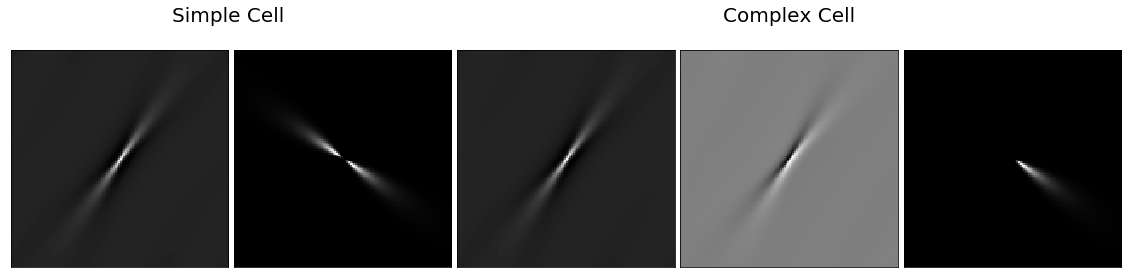

In [13]:
# MC neuron
N = 128
stdContrast = 0.1
fM_neur = 2.85
fS_neur = 2.0
th_neur = 35.0
thS_neur = 5.0
octa = 1

Fneur = mcSpatialKernel(N, fM_neur, fS_neur, th_neur, thS_neur, stdContrast=stdContrast, octa=octa)
Neur = np.fft.fftshift(np.fft.ifft2(Fneur, norm='ortho').real)

FneurC = mcSpatialKernel(N, fM_neur, fS_neur, th_neur, thS_neur, stdContrast=stdContrast, octa=octa, cplx=1)
NeurC = np.fft.fftshift(np.fft.ifft2(FneurC, norm='ortho'))


fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(20, 4));
fig.subplots_adjust(wspace=0.0, hspace=0.2)

for k in range(5):
    ax[k].xaxis.set_visible(False);
    ax[k].yaxis.set_visible(False);

ax[0].imshow(Neur, cmap='gray');
ax[1].imshow(np.absolute(shift(Fneur)), cmap='gray');
ax[2].imshow(NeurC.real, cmap='gray');
ax[3].imshow(NeurC.imag, cmap='gray');
ax[4].imshow(np.absolute(shift(FneurC)), cmap='gray');
ax[0].set_title('Simple Cell',fontsize=20,x=1., y=1.1)
ax[3].set_title('Complex Cell',fontsize=20, y=1.1);

### Neural Population
The neural population comprises a total of 18 neurons among which 6 have orientation bandwidth $\theta_S \in \{4.0,6.0,8.0,10.0,12.0,14.0\}$, 6 have a fixed orientation bandwidths but with a further different non linearity with exponent $\{1.2,1.4,1.6,1.8,2.0,2.2\}$ and 6 last are complex neurons (phase invariance) with orientation bandwidth $\theta_S \in \{4.0,6.0,8.0,10.0,12.0,14.0\}$.

In [24]:
# MC neuron
N_neur = 18
octa = 1.0
stdContrast = 0.1
fM_neur = 2.85
# fS_neurList = np.array([0.5,0.75,1.0,1.25,1.5,1.75])#
fS_neur = 1.5
th_neur = 0.0
# thS_neur = 5.0 #
thS_neurList = np.array([4.0,6.0,8.0,10.0,12.0,14.0,\
                         8.0, 8.0, 8.0, 8.0, 8.0, 8.0,\
                         4.0,6.0,8.0,10.0,12.0,14.0])

Neur = np.zeros((N,N,N_neur), dtype=np.complex128)

for k in range(N_neur):
    if k>11:
        Fneur = mcSpatialKernel(N, fM_neur, fS_neur, th_neur, thS_neurList[k],\
                                stdContrast=stdContrast, octa=octa, cplx=1)
    else:
        Fneur = mcSpatialKernel(N, fM_neur, fS_neur, th_neur, thS_neurList[k],\
                                stdContrast=stdContrast, octa=octa)
    Neur[:,:,k] = np.fft.fftshift(np.fft.ifft2(Fneur, norm='ortho'))

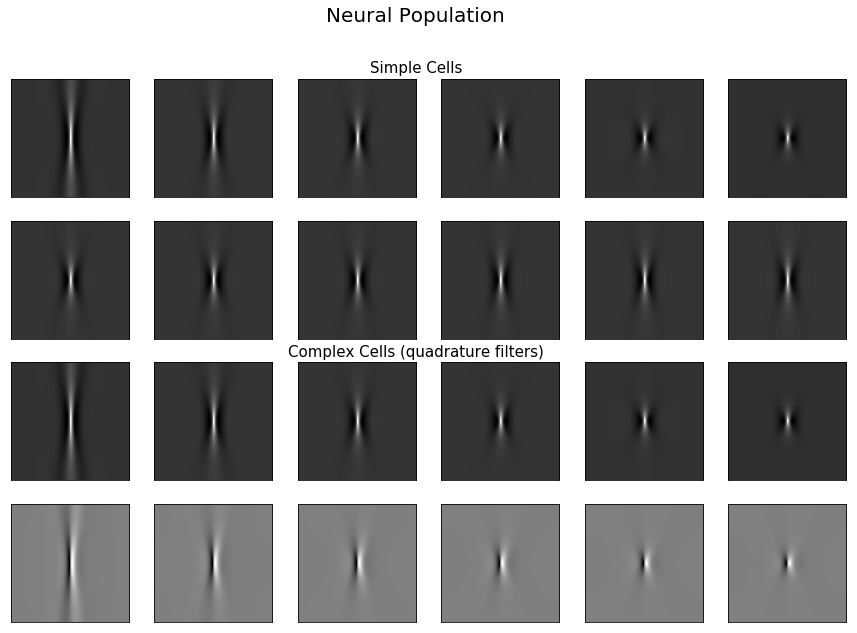

In [84]:
fig, ax = plt.subplots(nrows=4, ncols=6,figsize=(15, 10));
k = 0
for i in range(3):
    for j in range(6):
        if i == 2:
            ax[i,j].imshow(Neur[:,:,k].real, cmap='gray')
            ax[i+1,j].imshow(Neur[:,:,k].imag, cmap='gray')
            ax[i+1,j].xaxis.set_visible(False);
            ax[i+1,j].yaxis.set_visible(False);
        else:
            ax[i,j].imshow(Neur[:,:,k].real, cmap='gray')
        ax[i,j].xaxis.set_visible(False);
        ax[i,j].yaxis.set_visible(False);
        k+=1
        
fig.suptitle('Neural Population', fontsize=20);
ax[0,2].set_title('Simple Cells', fontsize=15, x= 1.0);
ax[2,2].set_title('Complex Cells (quadrature filters)', fontsize=15, x= 1.0);

### Tested Parameters using DG

In [27]:
# experiment param
nSamp = 24
fMmin, fMmax = 0.2, 12.0
thmin, thmax = -90.0, 90.0
fM_list = np.linspace(fMmin,fMmax,nSamp)
th_list = np.linspace(thmin,thmax,nSamp)

# non-linear functions
softplus = lambda x,al: np.logaddexp(0,1.0*x)/al
relu = lambda x,al: np.maximum(0,x)/al

In [33]:
# DG
framePerSecond = 100
N = 128
fM = 6.0
th = 0.0
const = 128.0
v = 1.0

DG = driftingGrating(framePerSecond=framePerSecond, N=N, chooseDev=1)
DG.initGPU()
DG.dgParam(const=const, fM=fM, th=th, v=v, it=0)

Platform: Intel(R) OpenCL
Devices:
[0]: Intel(R) HD Graphics
[1]: Intel(R) Core(TM) i7-7560U CPU @ 2.40GHz
Choose the device [0]:1


/usr/local/lib/python3.5/dist-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


### Simulation
Stimulus duration is 500 ms.
We only keep the firing rate elicited by one frame (100 frames per second)

In [40]:
DT = 50
frStock = np.zeros((Neur.shape[2],nSamp,nSamp,DT))
#neurFire = np.zeros((Neur.shape[2],nSamp,nSamp,10*DT))
nonLin = np.array([1.2,1.4,1.6,1.8,2.0,2.2])

for i in range(nSamp):
    for j in range(nSamp):
        DG.dgParam(const=const, fM=fM_list[i], th=th_list[j], v=v, it=DG.it)
        
        for t in range(DT):
            I = DG.getFrame()
            dotP = np.tensordot(I,Neur) 
            fr = relu(dotP,10000)
            fr[:12] = fr[:12].real
            fr[6:12] = fr[6:12]**nonLin
            fr[12:] = np.sqrt(np.conj(fr[12:])*fr[12:])
            frStock[:,i,j,t] = fr
            #fire = np.random.poisson(fr[:,np.newaxis],(Neur.shape[2],10))
            #neurFire[:,i,j,10*t:10*(t+1)] = fire

        clear_output(wait=True)
        print('Iteration : %i, %i'%(i,j))
        sys.stdout.flush()

Iteration : 23, 23


### Spatial Frequency and Orientation Tuning Curves

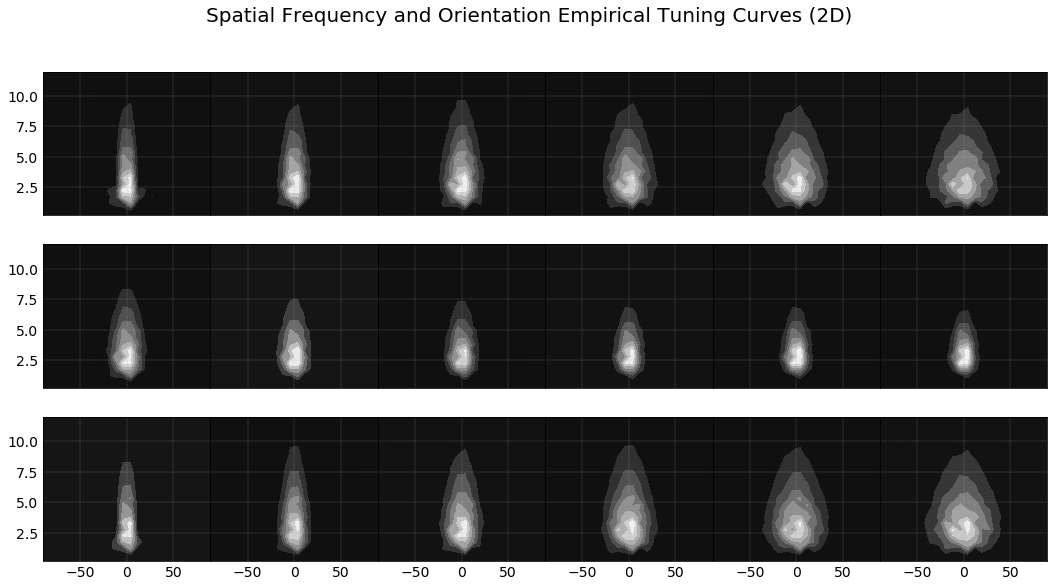

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(18, 9));
fig.subplots_adjust(wspace=0.0, hspace=0.2)

tunCur = frStock.sum(axis=3)

for i in range(N_neur//3):
    ax[0,i].contourf(th_list,fM_list,tunCur[i,:,:], cmap='gray');
    ax[1,i].contourf(th_list,fM_list,tunCur[6+i,:,:], cmap='gray');
    ax[2,i].contourf(th_list,fM_list,tunCur[12+i,:,:], cmap='gray');

for i in range(6):
    ax[0,i].tick_params(axis='both', which='major', labelsize=14, pad=5, length=8, width=1)
    ax[1,i].tick_params(axis='both', which='major', labelsize=14, pad=5, length=8, width=1)    
    ax[2,i].tick_params(axis='both', which='major', labelsize=14, pad=5, length=8, width=1)
    
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    
    if i>0:
        plt.setp(ax[0,i].get_yticklabels(), visible=False)
        plt.setp(ax[1,i].get_yticklabels(), visible=False)
        plt.setp(ax[2,i].get_yticklabels(), visible=False)
    
    for j in range(3):
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].grid(ls='-.', lw=0.25)
    
fig.suptitle('Spatial Frequency and Orientation Empirical Tuning Curves (2D)', fontsize=20);

### Tuning Curve Fit
We use the distributions used to generate neuron's receptive field (ie MC parametric distribution: log-normal and von-mises). 

In [44]:
vonmise = lambda x,mu,sig: stats.vonmises.pdf(2*(x-mu)*np.pi/180.0,1.0/ (4*(sig*np.pi/180.0)**2))

octaveBand = lambda octave: np.sqrt(np.exp((octave/np.sqrt(8)*np.sqrt(np.log(2)))**2)-1)

lognorm = lambda x,mu,sig: stats.lognorm.pdf(x/(mu*(1+octaveBand(sig)**2)),\
                                                np.sqrt(np.log(1+octaveBand(sig)**2)))

def tunCurve(sParam,nParam):
    return nParam[4]+nParam[5]*vonmise(sParam[1],nParam[2],nParam[3])**0.5\
            *lognorm(sParam[0],nParam[0],nParam[1])**0.5

fM_LIST, th_LIST = np.meshgrid(fM_list, th_list)    
    
res = ()
options = {'gtol': 1e-7,'ftol': 1e-12}
x0 = np.array([3.2,2.4,0.0,2.4,0.0,50.0])
# x0 = np.array([fM_neur,1.0,th_neur,5.0,1.0,1.0])

    
for i in range(Neur.shape[2]):    
    tun = tunCur[i,:,:]
    def obj(nParam):
        f = tunCurve(np.array([fM_LIST,th_LIST]), nParam).T
        return np.linalg.norm(f-tun)**2
    res += (opt.minimize(obj, x0=x0, method='L-BFGS-B', options=options),)

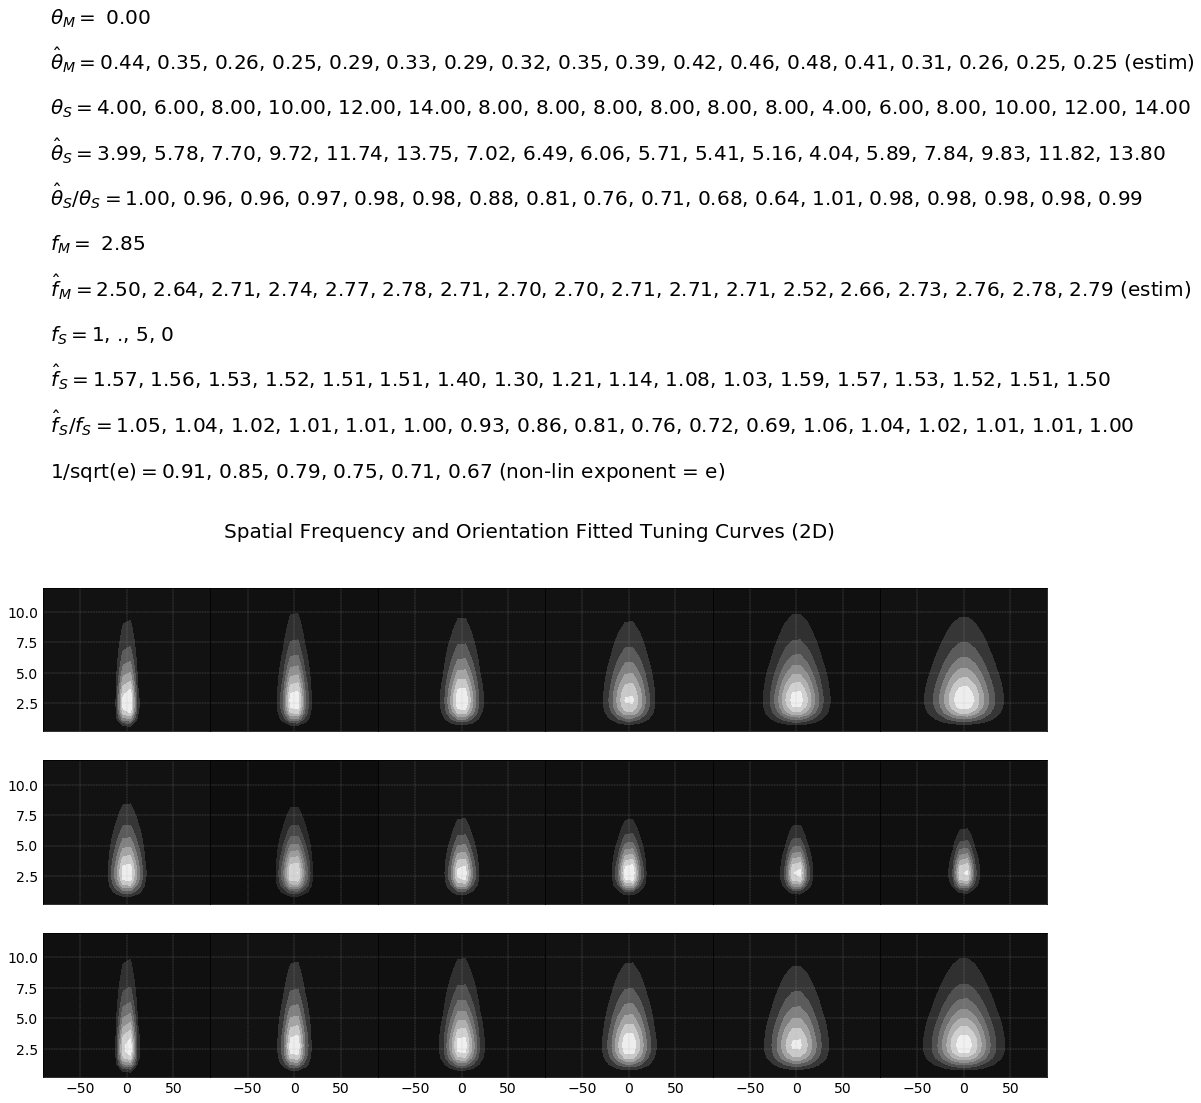

In [51]:
x = np.zeros((6,Neur.shape[2]))
for i in range(Neur.shape[2]):
    x[:,i] = res[i]['x']
    
tunCurFit = np.zeros((Neur.shape[2],nSamp,nSamp))
tunCurFitOri = np.zeros((Neur.shape[2],nSamp))
tunCurFitfM = np.zeros((Neur.shape[2],nSamp))

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(18, 9));
fig.subplots_adjust(wspace=0.0, hspace=0.2)

for i in range(Neur.shape[2]//3):

    tunCurFit[i,:,:] = tunCurve(np.array([fM_LIST,th_LIST]), x[:,i]).T
    tunCurFit[6+i,:,:] = tunCurve(np.array([fM_LIST,th_LIST]), x[:,6+i]).T
    tunCurFit[12+i,:,:] = tunCurve(np.array([fM_LIST,th_LIST]), x[:,12+i]).T
    
    ax[0,i].contourf(th_list,fM_list,tunCurFit[i,:,:], cmap='gray');
    ax[1,i].contourf(th_list,fM_list,tunCurFit[6+i,:,:], cmap='gray');
    ax[2,i].contourf(th_list,fM_list,tunCurFit[12+i,:,:], cmap='gray');
    
for i in range(6):
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    
    if i>0:
        for j in range(3):
            plt.setp(ax[j,i].get_yticklabels(), visible=False)
        
    for j in range(3):
        ax[j,i].tick_params(axis='both', which='major', labelsize=14, pad=5, length=8, width=1)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].grid(ls='-.', lw=0.25)
    
fig.suptitle('Spatial Frequency and Orientation Fitted Tuning Curves (2D)', fontsize=20); 

dtxt = 0.25
fig.text(0.13,1.5+dtxt,r'$\theta_M = $ %.2f'%th_neur, fontsize=20)
txt0 = ', '.join('{:0.2f}'.format(x[2,i]) for i in range(18))
fig.text(0.13,1.43+dtxt,r'$\hat \theta_M = $'+txt0+' (estim)', fontsize=20)
txt1 = ', '.join('{:0.2f}'.format(thS_neurList[i]) for i in range(18))
fig.text(0.13,1.36+dtxt,r'$\theta_S = $'+txt1, fontsize=20)
txt2 = ', '.join('{:0.2f}'.format(x[3,i]) for i in range(18))
fig.text(0.13,1.29+dtxt,r'$\hat \theta_S = $'+txt2, fontsize=20)
txt3 = ', '.join('{:0.2f}'.format(x[3,i]/thS_neurList[i]) for i in range(18))
fig.text(0.13,1.22+dtxt,r'$\hat \theta_S/\theta_S= $'+txt3, fontsize=20)


fig.text(0.13,1.15+dtxt,r'$f_M = $ %.2f'%fM_neur, fontsize=20)
txt4 = ', '.join('{:0.2f}'.format(x[0,i]) for i in range(18))
fig.text(0.13,1.08+dtxt,r'$\hat f_M = $'+txt4+' (estim)', fontsize=20)
txt5 = ', '.join('{:0.2f}'.format(fS_neur))
fig.text(0.13,1.01+dtxt,r'$f_S = $'+txt5, fontsize=20)
txt6 = ', '.join('{:0.2f}'.format(x[1,i]) for i in range(18))
fig.text(0.13,0.94+dtxt,r'$\hat f_S = $'+txt6, fontsize=20)
txt7 = ', '.join('{:0.2f}'.format(x[1,i]/fS_neur) for i in range(18))
fig.text(0.13,0.87+dtxt,r'$\hat f_S/f_S= $'+txt7, fontsize=20)
txt8 = ', '.join('{:0.2f}'.format(1/np.sqrt(nonLin[i])) for i in range(6))
fig.text(0.13,0.8+dtxt,r'1/sqrt(e)$= $'+txt8+' (non-lin exponent = e)', fontsize=20);

In [52]:
framePerSecond = 100
overSamp = 2

fM = 2.85
fS = 1.0
octa = 1
th = -90
thS = 1.5
fT = 10.0

v = 0.0
vv = v*np.array([0,1])/overSamp # in px per frame

MC = motionCloud(framePerSecond=framePerSecond, overSamp=overSamp, N=N, chooseDev=1, show=0)
MC.mcKernel(fM, fS, th, thS, fT, vv, octa)
MC.initGPU()

Platform: Intel(R) OpenCL
Devices:
[0]: Intel(R) HD Graphics
[1]: Intel(R) Core(TM) i7-7560U CPU @ 2.40GHz
Choose the device [0]:1


/usr/local/lib/python3.5/dist-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [55]:
nSamp1 = 24
nSamp2 = 12

thSmin, thSmax = 2.5, 21.5
thmin, thmax = -90.0, 90.0
thS_list = np.linspace(thSmin,thSmax,nSamp2)
th_list = np.linspace(thmin,thmax,nSamp1)

DT = 1000
frStock = np.zeros((Neur.shape[2],nSamp2,nSamp1,DT))
# neurFire = np.zeros((Neur.shape[2],nSamp2,nSamp1,10*DT))

for i in range(nSamp2):
    for j in range(nSamp1):
        MC.mcKernel(fM, fS, th_list[j], thS_list[i], fT, vv, octa)
        MC.updateGPU()
            
        for t in range(DT):
            I = MC.getFrame()
            if np.isnan(I[0,0]):
                print('Error: %i'%i)
                MC = motionCloud(framePerSecond=framePerSecond, overSamp=overSamp, N=N, chooseDev=1, show=0)
                MC.mcKernel(fM, fS, th_list[j], thS_list[i], fT, vv, octa)
                MC.initGPU()
                I = MC.getFrame()
                
            dotP = np.tensordot(I,Neur) 
            fr = relu(dotP,10000)
            fr[:12] = fr[:12].real
            fr[6:12] = fr[6:12]**nonLin
            fr[12:] = np.sqrt(np.conj(fr[12:])*fr[12:])
            frStock[:,i,j,t] = fr
            
        clear_output(wait=True)
        print('Iteration : %i, %i'%(i,j))
        sys.stdout.flush()

Iteration : 11, 23


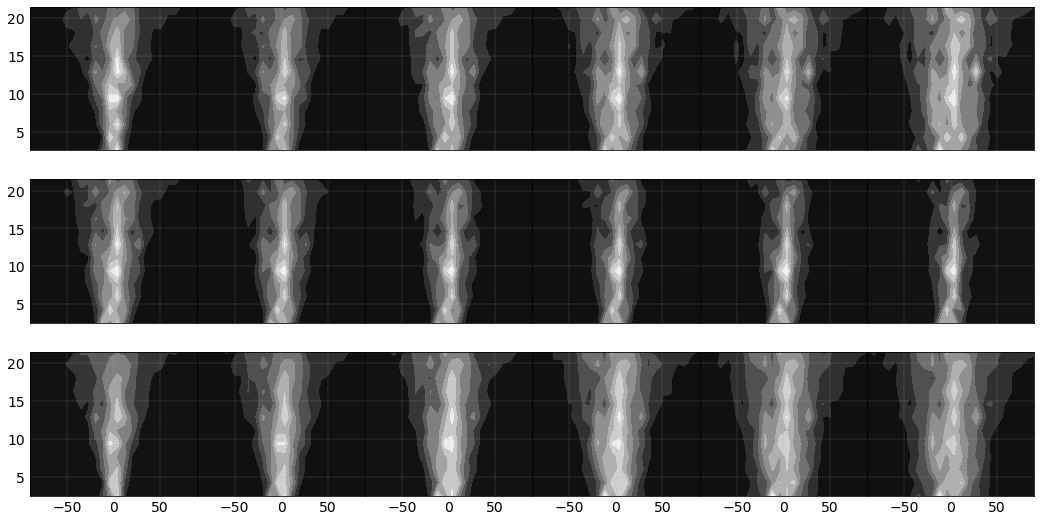

In [58]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(18, 9));
fig.subplots_adjust(wspace=0.0, hspace=0.2)

tunCurMC = frStock.sum(axis=3)

for i in range(N_neur//3):
    ax[0,i].contourf(th_list,thS_list,tunCurMC[i,:,:], cmap='gray');
    ax[1,i].contourf(th_list,thS_list,tunCurMC[6+i,:,:], cmap='gray');
    ax[2,i].contourf(th_list,thS_list,tunCurMC[12+i,:,:], cmap='gray');

for i in range(6):
    
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    
    if i>0:
        for j in range(3):
            plt.setp(ax[j,i].get_yticklabels(), visible=False)
            
    for j in range(3):
        ax[j,i].tick_params(axis='both', which='major', labelsize=14, pad=5, length=8, width=1)    
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].grid(ls='-.', lw=0.25)
    

In [67]:
def tunCurve(sParam,nParam):
    return nParam[2]+(nParam[3]*sParam[0]+nParam[4])\
            *vonmise(sParam[1],nParam[0],np.sqrt(nParam[1]**2+sParam[0]**2))**0.5

thS_LIST, th_LIST = np.meshgrid(thS_list, th_list)    
    
res = ()
options = {'gtol': 1e-16,'ftol': 1e-16}
x0 = np.array([0.0,5.0,0.0,10.0,300.0])
bounds = ((None,None),(0.0,None),(None,None),(None,None),(None,None))
    
for i in range(Neur.shape[2]):    
    tun = tunCurMC[i,:,:]
    def obj(nParam):
        f = tunCurve(np.array([thS_LIST,th_LIST]), nParam).T
        return np.linalg.norm(f-tun)**2
    res += (opt.minimize(obj, x0=x0, method='L-BFGS-B', bounds=bounds, options=options),)

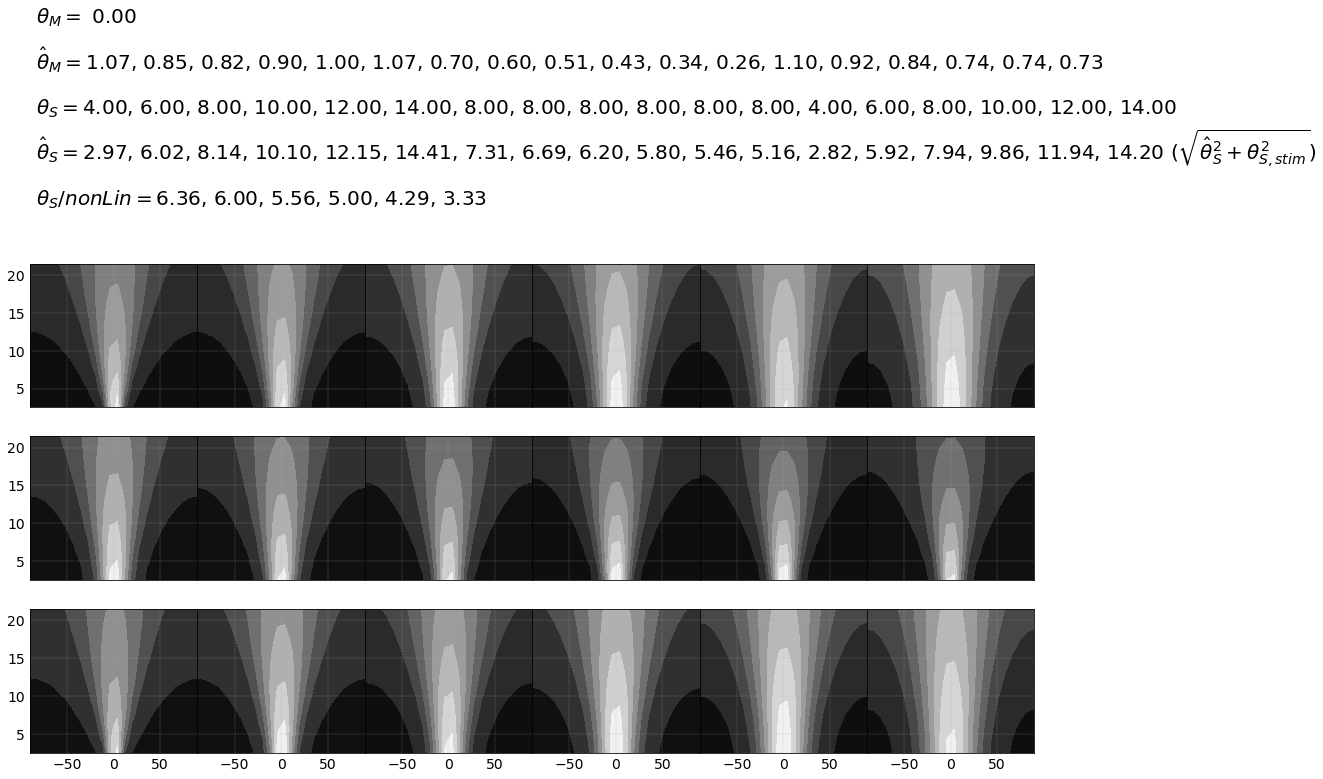

In [68]:
x = np.zeros((5,Neur.shape[2]))
for i in range(Neur.shape[2]):
    x[:,i] = res[i]['x']
    
tunCurMCFit = np.zeros((Neur.shape[2],nSamp2,nSamp1))

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(18, 9));
fig.subplots_adjust(wspace=0.0, hspace=0.2)

for i in range(Neur.shape[2]//3):

    tunCurMCFit[i,:,:] = tunCurve(np.array([thS_LIST,th_LIST]), x[:,i]).T
    tunCurMCFit[6+i,:,:] = tunCurve(np.array([thS_LIST,th_LIST]), x[:,6+i]).T
    tunCurMCFit[12+i,:,:] = tunCurve(np.array([thS_LIST,th_LIST]), x[:,12+i]).T
    
    ax[0,i].contourf(th_list,thS_list,tunCurMCFit[i,:,:], cmap='gray');
    ax[1,i].contourf(th_list,thS_list,tunCurMCFit[6+i,:,:], cmap='gray');
    ax[2,i].contourf(th_list,thS_list,tunCurMCFit[12+i,:,:], cmap='gray');
    
for i in range(6):
    
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    
    if i>0:
        for j in range(3):
            plt.setp(ax[j,i].get_yticklabels(), visible=False)
            
    for j in range(3):
        ax[j,i].tick_params(axis='both', which='major', labelsize=14, pad=5, length=8, width=1)    
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].grid(ls='-.', lw=0.25)

    
dtxt = -0.25
fig.text(0.13,1.5+dtxt,r'$\theta_M = $ %.2f'%th_neur, fontsize=20)
txt0 = ', '.join('{:0.2f}'.format(x[0,i]) for i in range(18))
fig.text(0.13,1.43+dtxt,r'$\hat \theta_M = $'+txt0, fontsize=20)
txt1 = ', '.join('{:0.2f}'.format(thS_neurList[i]) for i in range(18))
fig.text(0.13,1.36+dtxt,r'$\theta_{S} = $'+txt1, fontsize=20)
txt2 = ', '.join('{:0.2f}'.format(x[1,i]) for i in range(18))
fig.text(0.13,1.29+dtxt,r'$\hat \theta_S = $'+txt2+\
         r' ($\sqrt{\hat \theta_S^2 + \theta_{S,stim}^2}$)', fontsize=20)
txt3 = ', '.join('{:0.2f}'.format(thS_neurList[5-i]/nonLin[5-i]) for i in range(6))
fig.text(0.13,1.22+dtxt,r'$\theta_S/nonLin= $'+txt3, fontsize=20);

In [66]:
np.set_printoptions(suppress=True,precision=2,linewidth=100) 
print(x[4,:])

[ 306.16  296.08  302.57  307.88  313.42  321.79  287.64  276.84  269.49  265.09  263.32  263.95
  334.23  328.73  332.33  334.04  339.33  347.69]
